##### Concurrency 2021/2022 - Computer Science
# Lecture 2 - Deutsch Algorithm

1. [Functions and libraries](#review)
2. [Balanced vs constant functions](#functions)
3. [Deutsch's Algorithm](#Deutsch)
3. [Deutsch-Jozsa Algorithm](#Deutsch-jozsa)

### 1. Function and libraries

In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
from qiskit.tools.visualization import plot_histogram, visualize_transition
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def execute_circuit(qc, shots=1024, device="qasm", decimal=False, reversed=False):
    
    #define backend
    if device == "qasm":
        device = Aer.get_backend('qasm_simulator')
        #get counts
        counts = execute(qc, device, shots=shots).result().get_counts()
        
        if decimal:
            if reversed:
                counts = dict((int(a[::-1],2),b) for (a,b) in counts.items())
            else:
                counts = dict((int(a,2),b) for (a,b) in counts.items())
        else:
            if reversed:
                counts = dict((a[::-1],b) for (a,b) in counts.items())
            else:
                counts = dict((a,b) for (a,b) in counts.items())

        return counts
    
    elif device=="statevector":
        device = Aer.get_backend('statevector_simulator')
        state_vector = execute(qc, device).result().get_statevector()

        return state_vector

### 2. Balanced vs constant boolean functions <a id="functions"></a>

Let's consider Boolean function $f:\{0,1\} \rightarrow \{0,1\}$ that can either be balanced or constant.

- **Constant**: its output is always 0 or always 1
- **Balanced**: outputs 0 for half of the input value and 1 for the other half

##### <span style="color: red;">Question:</span> - The XOr function is balanced or constant? 

##### <span style="color: red;">Exercise 3:</span> - Implement a quantum circuit that performs the XOR function on every possible input in superposition 

Truth table for the XOr logic gate
|x_0|x_1|x_2|        
|-|-|-|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

In [16]:
def xor_function(ctrl1=0, ctrl2=1, target=2, n_qubits=3):

    qc = QuantumCircuit(n_qubits)

    #state |10>
    qc.x(1)
    qc.ccx(0,1,2)
    qc.x(1)
    
    #state |01>
    qc.x(0)
    qc.ccx(0,1,2)
    qc.x(0)
    
    return qc

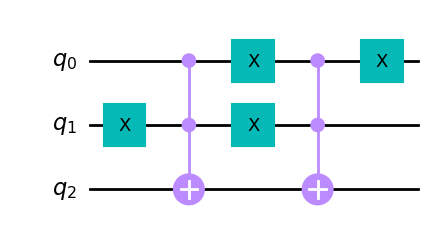

In [17]:
xor = xor_function()
xor.draw(output="mpl")

Suppose a **classical** algorithm that finds if the function is actually balanced or constant. The algorithm has to run through all the four possible combinations. In average the algorithm has to run through half the combinations in order to discover if the function is balanced .

In general, if we have $n$ bit string , we have to check $\frac{2^n}{2} + 1$. 

The quantum algorithm from Deutsch promises to find if the function is balanced or constant in a single step! 

But how ? We have seen that simply acting in superposition does not solve the problem because we will need to run the quantum circuit several times do the stochastic nature! 

The novel trick of the algorithm is actually collapse the superposition into a deterministic state of interest using INTERFERENCE ! Not possible in classical computing !

## 3. Deutsch's algorithm <a id='deutsch'></a>

<p align="center">
  <img width="600" height="200" src="images/deutsch.png">
</p>

$U_f$ is our function, usually seen as an oracle, or a black-box function that we want to find if it's balanced or constant

##### <span style="color: red;">Exercise 4:</span> - Suppose that the black-box function is actually the CNOT function. Implement the full deutsch circuit. 

In [18]:
def U_f(n_qubits=2):

    qc = QuantumCircuit(n_qubits+1)
    
    #apply CNOT gate
    qc.cx(0, 1)

    return qc


def deutsch(U_f=None, n_qubits=2):
    cr = ClassicalRegister(1)
    qr = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr,cr)

    # first qubit
    qc.h(qr[0])

    #second qubit
    qc.x(qr[1])
    qc.h(qr[1])
    
    
    qc.barrier()

    #compose circuit with U_f
    qc = qc.compose(U_f)

    #interference first qubit

    #measure the first qubit 
    qc.measure(qr[0], cr[0])
    
    return qc

Create the deutsch circuit

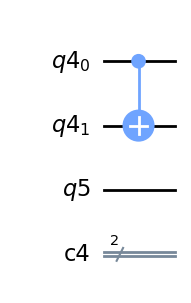

In [23]:
u_f = U_f()
qc = deutsch_jozsa(U_f=u_f, n_qubits=3)
qc.draw(output="mpl")

Execute the circuit and see the result

In [24]:
#qasm_backed = Aer.get_backend("qasm_simulator")
#result = execute(qc, qasm_backed, shots=1024).result()
#counts = result.get_counts()

counts = execute_circuit(qc, shots=1024)
plot_histogram(counts)

QiskitError: 'No counts for experiment "0"'

What happens if we have the identity as $U_f$? Now, we have a constant function. Test and see what is the result. 

Do you noticed what happened? 

* If we have a **constant** function we measure the state $|0\rangle$ with certainty
* if we have **balanced** function we measure the state $|1\rangle$ with probability 1 !! 

##### why ? Let's go step by step


1) Initial state - $|00\rangle$
2) Create uniform superposition in the first qubit ------> $(H \otimes I) |00\rangle $
    $$ \frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) |0\rangle = \frac{1}{\sqrt{2}}( |00\rangle + |10\rangle)$$
3) Apply $x$ gate to the second qubit - $(I \otimes X) \frac{1}{\sqrt{2}}( |00\rangle + |10\rangle)$
   $$ \frac{1}{\sqrt{2}}( |01\rangle + |11\rangle) $$
4) Create uniform superposition in the second qubit (attention to the signs !) ----->  $(I \otimes H) \frac{1}{\sqrt{2}}( |01\rangle + |11\rangle) $
   
$$H = 
\frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}
$$

$$ \frac{1}{\sqrt{2}}( |0\rangle \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) + |1\rangle \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle )) = \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle)$$

5) Apply $U_f = I$ - $I(\frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle))$

    $$ \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle))$$

6) Apply hadamard to the first qubit ----> $(H \otimes I) \frac{1}{2}(|00\rangle - |01\rangle + |10\rangle - |11\rangle))$

    $$\frac{1}{2}\left[\frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) |0\rangle - \frac{1}{\sqrt{2}}( |0\rangle + |1\rangle ) |1\rangle + \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) |0\rangle - \frac{1}{\sqrt{2}}( |0\rangle - |1\rangle ) |1\rangle \right] $$

    $$\frac{1}{2\sqrt{2}}\left[|00\rangle + |10\rangle - |01\rangle -|11\rangle +|00\rangle -|10\rangle - |01\rangle + |11\rangle \right] $$

    $$\frac{1}{2\sqrt{2}} \left[2|00\rangle - 2|01\rangle \right]$$

Thus, we can see that by applying the hadamard in the first qubit after the function , we created interference, leaving only states with first qubit=0. We have a constant function. 

If we repeat the process for CNOT function instead, we will be measuring state $|1\rangle$ in the first qubit instead. 


## 4. Deutsch-Jozsa algorithm <a id='deutsch-josza'></a>

Deutsch-Josza algorithm is the generalization of the previous algorithm for boolean functions for $n$ bit strings rather than single bit string inputs.

<p align="center">
  <img width="700" height="200" src="images/dj.png">
</p>

The mechanics is essentially the same here, the only differences are:

* Hadamard uniform superposition over all qubits instead of a single qubit
* We will measure all input qubits instead of the single qubit
* $P(000 \dots 0)=0$ if the function is **constant**
* $P(111 \dots 1)=1$ if the function is **balanced**


##### <span style="color: red;">Exercise 5:</span> - Suppose that the black-box function is the XOR function. Implement the full deutsch-josza algorithm. 

In [22]:
def deutsch_jozsa(U_f=None, n_qubits=3):

    cr = ClassicalRegister(n_qubits-1)
    qr = QuantumRegister(n_qubits-1)
    ancilla = QuantumRegister(1)
    qc = QuantumCircuit(qr,ancilla,cr)

    # qubits input

    #ancilla

    #compose circuit with U_f
    qc = qc.compose(U_f)

    #interference input qubits
        
    #measure the input qubits 
    
    return qc

In [ ]:
u_f = xor_function()
qc = deutsch_jozsa(U_f=u_f, n_qubits=3)
qc.draw(output="mpl")

In [ ]:
counts = execute_circuit(qc, shots=1024)
plot_histogram(counts)

Ciao for now :)